In [73]:
import theano
# theano.config.device = 'gpu'
# theano.config.floatX = 'float32'
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import numpy as np
from collections import defaultdict


num_class = 256
data_dir = '../256_ObjectCategories/'

## Generating data

In [74]:
def list_gen(data_dir):
    """
    generating lists of all images in each class
    :return: dict{"class_id": [image_paths]}
    """
    image_dirs = glob.glob(data_dir + '*')
    d = defaultdict(list)
    for idir in image_dirs:
        all_images = glob.glob(idir + '/*.jpg')
        label_id = int(idir.split('/')[-1].split('.')[0])-1
        if label_id > 255:
            continue
        np.random.shuffle(all_images)
        train_paths, val_paths, test_paths = all_images[:len(all_images)/10*8], all_images[len(all_images)/10*8:len(all_images)/10*9], all_images[len(all_images)/10*9:]
        train_labels, val_labels, test_labels = [label_id]*(len(all_images)/10*8), [label_id]*(len(all_images)/10), [label_id]*(len(all_images)/10)
        
        d['train_images'].append(train_paths)
        d['val_images'].append(val_paths)
        d['test_images'].append(test_paths)
        d['train_labels'].append(train_labels)
        d['val_labels'].append(val_labels)
        d['test_labels'].append(test_labels)
    return d

all_d = list_gen(data_dir)

In [75]:
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import np_utils
from keras.applications.imagenet_utils import preprocess_input

def load_data(image_paths, labels, crop_size):
    """
    Given list of paths, load images as one numpy array of shape
        (num_images, crop_size, crop_size, channel)
    :return X: image array
    "return y: one hot encoded labels
    """
    X = np.zeros((len(image_paths), crop_size, crop_size, 3))
    for i,path in enumerate(image_paths):
        X[i, :] = img_to_array(load_img(path, target_size=(crop_size, crop_size)))
    y = np_utils.to_categorical(labels)
    return X, y

crop_size = 224
all_per_class = 16
train_paths = []
val_paths = []
test_paths = []
train_labels = []
val_labels = []
test_labels = []
for i in xrange(num_class):
    train_paths += (all_d['train_images'][i][:all_per_class])
    val_paths += (all_d['val_images'][i][:all_per_class])
    test_paths += (all_d['test_images'][i][:all_per_class])
    train_labels += (all_d['train_labels'][i][:all_per_class])
    val_labels += (all_d['val_labels'][i][:all_per_class])
    test_labels += (all_d['test_labels'][i][:all_per_class])

X_train, y_train = load_data(train_paths, train_labels, crop_size)
X_val, y_val = load_data(val_paths, val_labels, crop_size)
X_test, y_test = load_data(test_paths, test_labels, crop_size)

X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [76]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    rescale=1./128)

datagen.fit(X_train)  # nothing to fit in fact...

## Model definition

In [220]:
import keras
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import SGD
from keras.initializations import normal


def getModel( output_dim ):
    ''' 
    Model definition
    :param output_dim: the number of classes (int)
    :return compiled model (keras.engine.training.Model)
    '''
    vgg_model = VGG16( weights='imagenet', include_top=True )
    vgg_out = vgg_model.layers[-2].output
    softmax_layer = Dense(output_dim, activation='softmax')(vgg_out)
    #Create new transfer learning model
    tl_model = Model( input=vgg_model.input, output=softmax_layer )

    #Freeze all layers of VGG16 and Compile the model
    for layer in vgg_model.layers:
        layer.trainable = False
    return tl_model

# model = getModel(num_class)
# model.summary()

In [78]:
# Model compiling
model = getModel(num_class, 'fc2')
# sgd = SGD(lr=1e-3, decay=1e-4, momentum=0.9, nesterov=True)  # Slow
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    samples_per_epoch=len(X_train), nb_epoch=10)

Epoch 1/10
1664/4096 [===========>..................] - ETA: 18s - loss: 7.9187 - acc: 0.0114

KeyboardInterrupt: 

## Training

In [9]:
# training 
num_epoch = 50
batch_size = 64

for sample_per_class in [2,4,8,16]:
    train = X_train.reshape((num_class, -1, crop_size, crop_size, 3))
    train = train[:, :sample_per_class].reshape((-1, crop_size, crop_size, 3))
    label = y_train.reshape((num_class, -1, num_class))
    label = label[:, :sample_per_class].reshape((-1, num_class))
    rmsmodel = getModel(num_class, 'fc2')
    rmsmodel.compile(optimizer='rmsprop',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
    rmsmodel.fit_generator(datagen.flow(train, label, batch_size=batch_size),
                           validation_data=datagen.flow(X_val, y_val, batch_size=batch_size),
                           nb_val_samples=2000,
                           samples_per_epoch=len(train), nb_epoch=num_epoch)

Epoch 1/50
512/512 [==============================] - 6s - loss: 10.2884 - acc: 0.0020 - val_loss: 7.5286 - val_acc: 0.0039
Epoch 2/50
512/512 [==============================] - 6s - loss: 6.5496 - acc: 0.0137 - val_loss: 6.1474 - val_acc: 0.0078
Epoch 3/50
512/512 [==============================] - 6s - loss: 5.7005 - acc: 0.0215 - val_loss: 5.9528 - val_acc: 0.0430
Epoch 4/50
512/512 [==============================] - 6s - loss: 5.0559 - acc: 0.0391 - val_loss: 5.8071 - val_acc: 0.0391
Epoch 5/50
512/512 [==============================] - 6s - loss: 4.4553 - acc: 0.0723 - val_loss: 5.2556 - val_acc: 0.0938
Epoch 6/50
512/512 [==============================] - 6s - loss: 3.8692 - acc: 0.1270 - val_loss: 5.0214 - val_acc: 0.0781
Epoch 7/50
512/512 [==============================] - 6s - loss: 3.3450 - acc: 0.1992 - val_loss: 4.7153 - val_acc: 0.1016
Epoch 8/50
512/512 [==============================] - 7s - loss: 2.8636 - acc: 0.2676 - val_loss: 5.1866 - val_acc: 0.0820
Epoch 9/50
512/

In [32]:
# Edit the output manually and store in the log file before runing this
train_loss=[[],[],[],[]]
val_loss=[[],[],[],[]]
train_accu=[[],[],[],[]]
val_accu=[[],[],[],[]]
with open('log', 'r') as f:  
    for i,line in enumerate(f.readlines()):
        fields = line.strip().split('\t')
        fields = fields[1:]
        idx = i/50
        train_loss[idx].append(float(fields[0].split(':')[-1]))
        train_accu[idx].append(float(fields[1].split(':')[-1]))
        val_loss[idx].append(float(fields[2].split(':')[-1]))
        val_accu[idx].append(float(fields[3].split(':')[-1]))

## Plotting

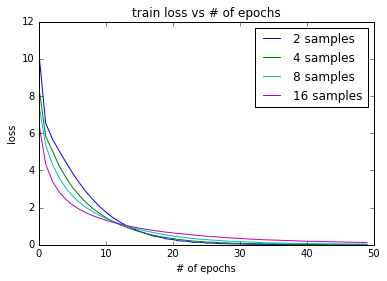

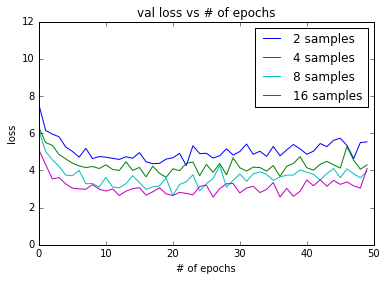

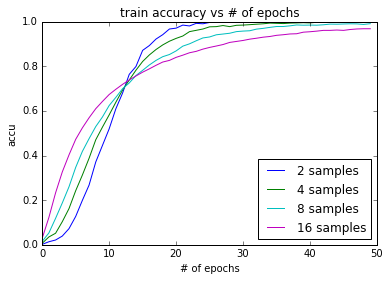

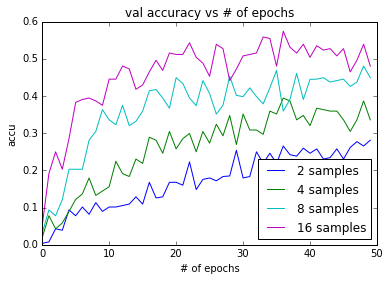

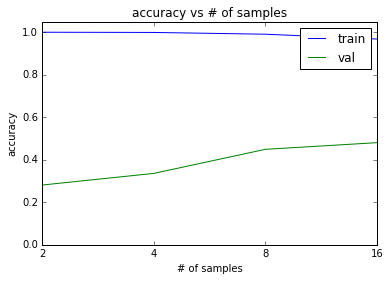

In [69]:
# plotting
c = ['b', 'g', 'c', 'm']

# train loss vs epoch
plt.figure()
ax = plt.subplot(111)
for i,sample_size in enumerate([2,4,8,16]):
    plt.plot(range(len(train_loss[i])), train_loss[i], '-', color=c[i], 
             label='{} samples'.format(sample_size))
#     plt.plot(range(len(val_loss[i])), val_loss[i], '--', color=c[i], 
#              label='{} img/class val'.format(sample_size))
plt.title('train loss vs # of epochs')
ax.legend(loc='upper right')
ylim = ax.get_ylim()
plt.xlabel('# of epochs')
plt.ylabel('loss')
plt.savefig('images/4aTrain.pdf')
plt.show()

# val loss vs epoch
plt.figure()
ax = plt.subplot(111)
for i,sample_size in enumerate([2,4,8,16]):
    plt.plot(range(len(val_loss[i])), val_loss[i], '-', color=c[i], 
             label='{} samples'.format(sample_size))
plt.title('val loss vs # of epochs')
ax.legend(loc='upper right')
ax.set_ylim(ylim)
plt.xlabel('# of epochs')
plt.ylabel('loss')
plt.savefig('images/4aVal.pdf')
plt.show()

# train accu vs epoch
plt.figure()
ax = plt.subplot(111)
for i,sample_size in enumerate([2,4,8,16]):
    plt.plot(range(len(train_accu[i])), train_accu[i], '-', color=c[i], 
             label='{} samples'.format(sample_size))
plt.title('train accuracy vs # of epochs')
ax.legend(loc='lower right')
plt.xlabel('# of epochs')
plt.ylabel('accu')
plt.savefig('images/4bTrain.pdf')
plt.show()

# val accu vs epoch
plt.figure()
ax = plt.subplot(111)
for i,sample_size in enumerate([2,4,8,16]):
    plt.plot(range(len(val_accu[i])), val_accu[i], '-', color=c[i], 
             label='{} samples'.format(sample_size))
plt.title('val accuracy vs # of epochs')
ax.legend(loc='lower right')
plt.xlabel('# of epochs')
plt.ylabel('accu')
plt.savefig('images/4bVal.pdf')
plt.show()

# training sample vs accu
plt.figure()
plt.plot(range(4), [train_accu[i][-1] for i in xrange(4)], label='train')
plt.plot(range(4), [val_accu[i][-1] for i in xrange(4)], label='val')
plt.xticks(range(4), ['2','4','8','16'])
plt.title('accuracy vs # of samples')
plt.legend(loc='lower right')
plt.ylim([0,1.05])
plt.xlabel('# of samples')
plt.ylabel('accuracy')
plt.savefig('images/4c.pdf')
plt.show()


In [85]:
# continue training
rmsmodel.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                       validation_data=datagen.flow(X_val, y_val, batch_size=64),
                       nb_val_samples=2000,
                       samples_per_epoch=len(X_train), nb_epoch=num_epoch)

Epoch 1/50
4096/4096 [==============================] - 47s - loss: 3.2192 - acc: 0.5613 - val_loss: 2.7964 - val_acc: 0.5791
Epoch 2/50
4096/4096 [==============================] - 51s - loss: 2.8498 - acc: 0.5969 - val_loss: 2.7435 - val_acc: 0.5850
Epoch 3/50
4096/4096 [==============================] - 53s - loss: 2.6111 - acc: 0.6238 - val_loss: 2.6770 - val_acc: 0.5904
Epoch 4/50
4096/4096 [==============================] - 54s - loss: 2.4036 - acc: 0.6394 - val_loss: 2.6425 - val_acc: 0.5996
Epoch 5/50
4096/4096 [==============================] - 54s - loss: 2.2327 - acc: 0.6560 - val_loss: 2.5536 - val_acc: 0.6055
Epoch 6/50
4096/4096 [==============================] - 54s - loss: 2.0840 - acc: 0.6765 - val_loss: 2.5972 - val_acc: 0.6055
Epoch 7/50
4096/4096 [==============================] - 54s - loss: 1.9440 - acc: 0.6953 - val_loss: 2.6022 - val_acc: 0.5991
Epoch 8/50
4096/4096 [==============================] - 54s - loss: 1.8241 - acc: 0.7104 - val_loss: 2.5575 - val_acc:

## Visualization
copying the idea from [julienr](https://github.com/julienr/ipynb_playground/blob/master/keras/convmnist/keras_cnn_mnist.ipynb)

In [201]:
# copying the idea from 
import pylab as pl
import matplotlib.cm as cm
import numpy.ma as ma
from mpl_toolkits.axes_grid1 import make_axes_locatable


def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)
    pl.savefig('images/4eConvFilter.pdf')

def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = i / ncols
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic


(-0.5, 223.5, 223.5, -0.5)

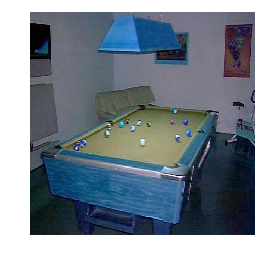

In [202]:
def original(img):
    tmp = np.zeros_like(img)
    for i in xrange(3):
        tmp[:,:,i] = img[:,:,i] - img[:,:,i].min()
    return tmp.astype(np.uint8)

plt.imshow(original(X_val[201]))
plt.savefig('images/4eOri.pdf')
plt.axis('off')

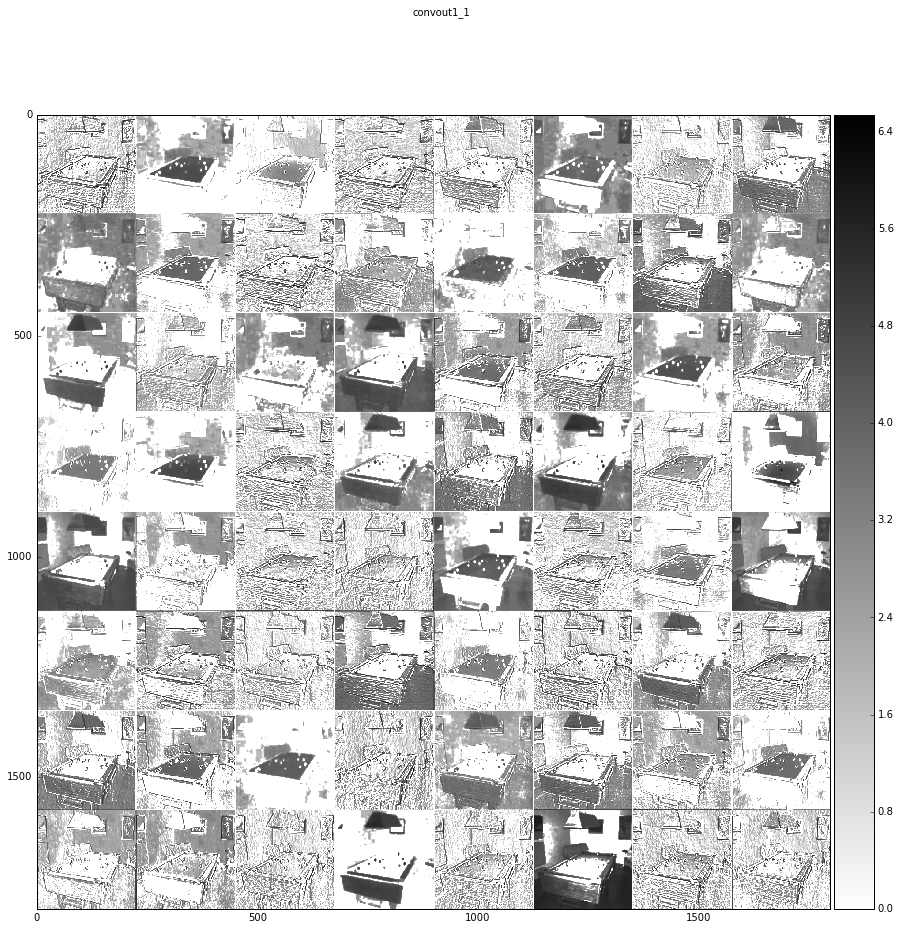

In [203]:
# get intermediate layer
conv11 = rmsmodel.get_layer('block1_conv1')  # -5 is the last conv
tmpmodel = Model(input=rmsmodel.input, output=conv11.output)

test_img = np.expand_dims(X_val[201], axis=0)
pred = tmpmodel.predict(test_img)
pred = np.log(1+pred.squeeze().transpose(2,0,1))  # contrast normalization

pl.figure(figsize=(15, 15))
pl.suptitle('convout1_1')
nice_imshow(pl.gca(), make_mosaic(pred, 8, 8), cmap=cm.binary)

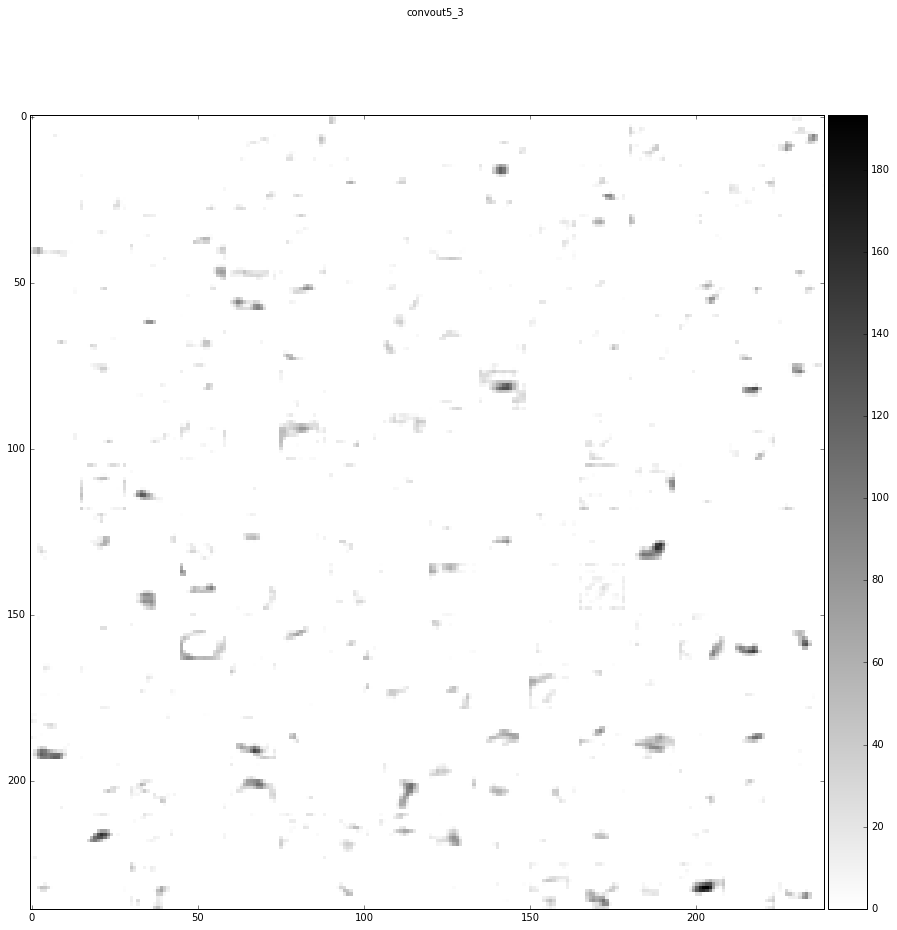

In [204]:
conv53 = rmsmodel.get_layer('block5_conv3')  # -6 is the last conv
tmpmodel = Model(input=rmsmodel.input, output=conv53.output)

test_img = np.expand_dims(X_val[201], axis=0)
pred = tmpmodel.predict(test_img)
pred = pred.squeeze().transpose(2,0,1)  # contrast normalization
pred = pred[:256]

pl.figure(figsize=(15, 15))
pl.suptitle('convout5_3')
nice_imshow(pl.gca(), make_mosaic(pred, 16, 16), cmap=cm.binary)

## Using intermediate Conv features

In [223]:
def getConvModel( output_dim, layer_name):
    ''' 
    Model definition
    :param output_dim: the number of classes (int)
    :return compiled model (keras.engine.training.Model)
    '''
    vgg_model = VGG16( weights='imagenet', include_top=True )
    vgg_out = vgg_model.get_layer(layer_name).output
    tmp = Flatten(name='flatten')(vgg_out)
    softmax_layer = Dense(output_dim, activation='softmax')(tmp)
    #Create new transfer learning model
    tl_model = Model( input=vgg_model.input, output=softmax_layer )

    #Freeze all layers of VGG16 and Compile the model
    for layer in vgg_model.layers:
        layer.trainable = False
    return tl_model

# model = getConvModel(num_class, 'block5_conv3')
# model.summary()

In [227]:
model4 = getConvModel(num_class, 'block5_conv3')
model4.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model4.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                     validation_data=datagen.flow(X_val, y_val, batch_size=batch_size),
                     nb_val_samples=2000,
                     samples_per_epoch=len(X_train), nb_epoch=num_epoch)

Epoch 1/50
4096/4096 [==============================] - 48s - loss: 14.9163 - acc: 0.0369 - val_loss: 14.6963 - val_acc: 0.0586
Epoch 2/50
4096/4096 [==============================] - 54s - loss: 13.7029 - acc: 0.1128 - val_loss: 13.6475 - val_acc: 0.1001
Epoch 3/50
4096/4096 [==============================] - 54s - loss: 13.0862 - acc: 0.1743 - val_loss: 13.6149 - val_acc: 0.0986
Epoch 4/50
4096/4096 [==============================] - 54s - loss: 12.8731 - acc: 0.1926 - val_loss: 13.6992 - val_acc: 0.1064
Epoch 5/50
4096/4096 [==============================] - 54s - loss: 12.7134 - acc: 0.2065 - val_loss: 13.9209 - val_acc: 0.0918
Epoch 6/50
4096/4096 [==============================] - 54s - loss: 12.6459 - acc: 0.2134 - val_loss: 13.5198 - val_acc: 0.1128
Epoch 7/50
4096/4096 [==============================] - 54s - loss: 12.6034 - acc: 0.2163 - val_loss: 13.3755 - val_acc: 0.1279
Epoch 8/50
4096/4096 [==============================] - 54s - loss: 12.5488 - acc: 0.2197 - val_loss: 13

In [228]:
model4.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                     validation_data=datagen.flow(X_val, y_val, batch_size=batch_size),
                     nb_val_samples=2000,
                     samples_per_epoch=len(X_train), nb_epoch=num_epoch)

Epoch 1/50
4096/4096 [==============================] - 49s - loss: 6.1980 - acc: 0.6099 - val_loss: 10.3946 - val_acc: 0.2485
Epoch 2/50
4096/4096 [==============================] - 54s - loss: 6.0595 - acc: 0.6182 - val_loss: 10.4822 - val_acc: 0.2500
Epoch 3/50
4096/4096 [==============================] - 54s - loss: 5.9103 - acc: 0.6299 - val_loss: 10.2590 - val_acc: 0.2632
Epoch 4/50
4096/4096 [==============================] - 54s - loss: 5.7713 - acc: 0.6379 - val_loss: 10.6219 - val_acc: 0.2285
Epoch 5/50
4096/4096 [==============================] - 54s - loss: 5.6261 - acc: 0.6450 - val_loss: 10.3473 - val_acc: 0.2451
Epoch 6/50
4096/4096 [==============================] - 54s - loss: 5.5375 - acc: 0.6543 - val_loss: 10.3221 - val_acc: 0.2554
Epoch 7/50
4096/4096 [==============================] - 54s - loss: 5.4772 - acc: 0.6582 - val_loss: 10.2619 - val_acc: 0.2539
Epoch 8/50
4096/4096 [==============================] - 54s - loss: 5.4418 - acc: 0.6606 - val_loss: 10.2392 - 

In [ ]:
T_range = [2,4,8,16]
def getTempModel(output_dim,T=1):
    def temp_softmax(x):
        return K.softmax(x/T)
    vgg_model = VGG16(weights='imagenet', include_top=True)

    vgg_out = vgg_model.layers[-1].output  # Last FC layer's output

    softmax_layer = Dense(output_dim=output_dim, activation=temp_softmax)(vgg_out)
    # Create new transfer learning model
    tl_model = Model(input=vgg_model.input, output=softmax_layer)

    # Freeze all layers of VGG16 and Compile the model
    vgg_model.trainable = False
    for layer in vgg_model.layers:
        layer.trainable = False
    # Confirm the model is appropriate

    return tl_model